In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

from pprint import pprint
from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

# Read data

In [26]:
df = pd.read_csv('../data/DEvideos.csv')

# Calculate categories

In [27]:
def assign_trending_category(row):
    if row['days_until_trending'] == 0:
        return 0 # 0 Days
    elif row['days_until_trending'] == 1:
        return 1 # 1 Day
    elif row['days_until_trending'] == 2:
        return 2 # 2 Days
    elif row['days_until_trending'] <= 5:
        return 3 # 3 - 5 Days
    else:
        return 4 # > 5 Days

df['days_until_trending'] = df.apply(lambda row: ((datetime.strptime(row['trending_date'], '%y.%d.%m') - datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z')).days + 1), axis=1)
df['trending_category'] = df.apply(assign_trending_category, axis=1)

# Drop unused data

In [28]:
df = df.drop(['trending_date','category_id', 'publish_time', 'views', 'likes','dislikes',
         'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled',
         'video_error_or_removed', 'description', 'days_until_trending',
          'channel_title'], axis=1)
df.head()

,video_id,title,tags,trending_category
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",1
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",2
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,"last week tonight trump presidency|""last week ...",1
3,AHtypnRk7JE,Das Fermi-Paradoxon,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",2
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",2


## Parse tags and convert

Breaks the tag-strings into single elements and formats them. The following formatting is applied:
* Remove enclosing quotation marks ("")
* convert to lower case
* remove all duplicates (due to conversion to lower)

After formatting, the tags are filter by the following rules. The tag will be excluded when:
* The tag matches the '[none]' tag
* The tag is a number (to remove time related data)
* The tag describes a country
* The tag describes a language (resource intensive due to large amount of languages)

In [29]:
filter_countries = True
countries = [s.name for s in pycountry.countries]
filter_languages = False # Resource intensive, use with care
languages = [s.name for s in pycountry.languages]

def isValidTag(s):
    return s != '[none]' \
    and not s.isnumeric() \
    and not(filter_countries and s in countries) \
    and not (filter_languages and s in languages)
def formatData(s):
    s2 = map(lambda x: x.strip('\"').lower(), s)
    res = []
    [res.append(x) for x in s2 if x not in res]
    return res

df['parsed_tags'] = df['tags'].str.split('|')\
    .apply(formatData)\
    .apply(lambda x: list(filter(isValidTag, x)))
df = df.drop('tags', axis=1)
df['parsed_tags'].head()


0    [inscope21, sing zu ende, gesangseinlagen, ges...
1    [kinder, ferngesteuert, kinder ferngesteuert, ...
2    [last week tonight trump presidency, last week...
3    [physik, wissenschaft, technik, science-fictio...
4    [kelly, missesvlog, kelly song, bausa, bausa w...
Name: parsed_tags, dtype: object

## Calculate tag count per video

In [30]:
df['tag_count'] = df.apply( lambda row: len(row['parsed_tags']), axis=1)
df.head()

,video_id,title,trending_category,parsed_tags,tag_count
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,1,"[inscope21, sing zu ende, gesangseinlagen, ges...",16
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,2,"[kinder, ferngesteuert, kinder ferngesteuert, ...",27
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,1,"[last week tonight trump presidency, last week...",4
3,AHtypnRk7JE,Das Fermi-Paradoxon,2,"[physik, wissenschaft, technik, science-fictio...",9
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),2,"[kelly, missesvlog, kelly song, bausa, bausa w...",5


## Calculate total tag counts

In [31]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
tag_counts = to_1D(df['parsed_tags']).value_counts()
tag_counts.name = "counts"

## Display top 20 tags

d:\programme\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

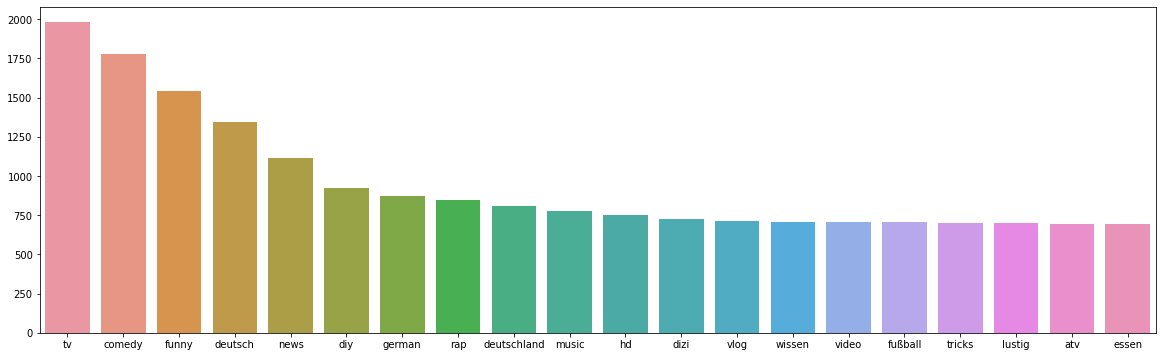

In [32]:
top_tags = tag_counts.head(20)
sns.barplot(top_tags.index, top_tags.values)

# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

## Convert tags into their own table

In [33]:
tags_df = df['parsed_tags'].apply(pd.Series)
tags_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,inscope21,sing zu ende,gesangseinlagen,gesang,gesungen,songs nachsingen,nachsingen,songs covern,carpool karaoke,witziger gesang,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kinder,ferngesteuert,kinder ferngesteuert,luke mockridge kinder,luke die woche und ich kinder,prank,verarschen,kiosk,funkgerät,falschgeld,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,last week tonight trump presidency,last week tonight donald trump,john oliver trump,donald trump,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,physik,wissenschaft,technik,science-fiction,außerirdische,alien,aliens,fermi,fermi-paradoxon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kelly,missesvlog,kelly song,bausa,bausa was du liebe nennst,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate tag usage

In [34]:
tags_df.iloc[:, 0].value_counts(normalize=True)

atv                                                              0.009257
çukur                                                            0.006242
fox                                                              0.005501
fußball                                                          0.004787
шарий                                                            0.004734
                                                                   ...   
#polarfuchs                                                      0.000026
lustige life hacks                                               0.000026
lg v30                                                           0.000026
thomas tuchel                                                    0.000026
ευα σε δωρο: ...απλα σου λεω ξεκαθαρα μου αρεσεις σαν αντρας     0.000026
Name: 0, Length: 9978, dtype: float64

## Convert tags to binary table

In [35]:
def boolean_df(item_lists, items):
    bool_dict={}
    for i, item in enumerate(items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

tags_start = 0
tags_end = 1000

#unique_items = tag_counts.where(lambda x: x > 500).dropna().index
unique_items = tag_counts.head(tags_end).tail(tags_end-tags_start).index
head_tags = df['parsed_tags']
tags_bool = boolean_df(head_tags, unique_items)
tags_bool.head()

,tv,comedy,funny,deutsch,news,diy,german,rap,deutschland,music,...,jimmy,failarmy kids,eminem,मैच,adults react,freshtorge,folge',bad friends,winter,phil laude
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Tags as correlation matrix

In [36]:
#tags_int = tags_bool.astype(int)
#tags_freq_mat = np.dot(tags_int.T, tags_int)
#np.fill_diagonal(tags_freq_mat, 0)

#tags_freq = pd.DataFrame(tags_freq_mat, columns = unique_items, index = unique_items)

#fix, ax = plt.subplots(figsize = (9,5))
#sns.heatmap(tags_freq, cmap = "Blues")
#plt.xticks(rotation=50)
#plt.savefig("heatmap.png", dpi = 300)



In [37]:
factors = {
    0 : 1.0,
    1 : 0.75,
    2 : 0.5,
    3 : 0.25,
    4 : 0.0
}

def get_factor(row):
    factor = row[0]
    return row[1:].apply(lambda x: factor if x else np.nan)

df_t = tags_bool.copy()
df_t.insert(0,'trending_category', df['trending_category'])
df_t['trending_category'] = df_t['trending_category'].map(lambda x: factors[x])
df_t = df_t.apply( get_factor, axis=1)

df_t

,tv,comedy,funny,deutsch,news,diy,german,rap,deutschland,music,...,jimmy,failarmy kids,eminem,मैच,adults react,freshtorge,folge',bad friends,winter,phil laude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
tag_factors = df_t.mean(axis = 0)
tag_factors.name = 'factors'

In [39]:
tag_metrics = tag_factors.to_frame().join(tag_counts)
tag_metrics['tag_weight'] = tag_metrics['factors'] * tag_metrics['counts']
tag_metrics.sort_values(by='tag_weight', ascending=False)

,factors,counts,tag_weight
tv,0.639576,1981,1267.00
comedy,0.630838,1777,1121.00
funny,0.646199,1539,994.50
deutsch,0.660104,1346,888.50
news,0.661580,1114,737.00
...,...,...,...
yerli hd dizi izle,0.534884,86,46.00
freshtorge,0.529412,85,45.00
brother,0.502874,87,43.75
deutschland sucht den superstar,0.500000,86,43.00


In [40]:
def mapTypes(values):
    v = map(tag_factors.get, values)
    return [x if x is not None else np.nan for x in v]

df['mapped_tags'] = df['parsed_tags'].apply(mapTypes)

In [41]:
def filterNanValues(x):
    filtered = [n for n in x if not np.isnan(n)]
    if len(filtered) == 0:
        return np.nan
    else:
        return np.mean(filtered)

df['tag_factor'] = df['mapped_tags'].apply(filterNanValues)
df[['title','tag_factor']]

,title,tag_factor
0,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,0.565462
1,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,0.635693
2,The Trump Presidency: Last Week Tonight with J...,0.686567
3,Das Fermi-Paradoxon,0.634190
4,18 SONGS mit Kelly MissesVlog (Sing-off),0.524194
...,...,...
40835,KINGDOM HEARTS III – E3 2018 Pirates of the Ca...,NaN
40836,YMS: The Visit,NaN
40837,Ungut umgeschult – Grünwald als Ersthelfer am ...,0.666488
40838,Assassin's Creed Odyssey: E3 2018 Welt-Enthüll...,0.641538


In [56]:
target_videos = df[df['tag_factor'].notna()]
target_videos[['video_id','title','tag_factor', 'tag_count']].sort_values(by=['tag_factor'], ascending=False).head(20)
#sorted_tags_df = tags_df.sort_values(by=['tag_factor'], ascending=False)

,video_id,title,tag_factor,tag_count
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,0.565462,16
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,0.635693,27
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,0.686567,4
3,AHtypnRk7JE,Das Fermi-Paradoxon,0.634190,9
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),0.524194,5
...,...,...,...,...
40830,DGzy8FE1Rhk,Shawn Mendes - Nervous,0.557266,6
40832,6wb8rqDeMlU,FarmVLOG#120 - Heu rein...Gülle raus,0.658687,50
40834,KYke3FFiyk4,Crime Patrol Dial 100 - Ep 796 - Full Episode ...,0.707560,32
40837,zSXG5I6Y2fA,Ungut umgeschult – Grünwald als Ersthelfer am ...,0.666488,33


## Data coverage

In [43]:
len(target_videos.index) / len(df.index)

0.7071008814887365

## Save tag factors to csv

In [44]:
tag_df = tag_metrics.sort_values(by='factors', ascending=False)
tag_df['tags'] = tag_df.index
tag_df[['tags','factors','counts']].to_csv('../data/tags.csv', header=['tag','factor','count'], index=False)

## Load Tags

In [72]:
tag_df = pd.read_csv('../data/tags.csv')
tag_df = tag_df.set_index('tag')
tag_df.head()

,factor,count
tag,,
nba,0.769531,128
müge anlı atv izle,0.760753,93
televizyon izle,0.760000,100
atv müge anlı,0.760000,100
müge anlı son dakika,0.760000,100


## Converter function

In [73]:
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)

,video_id,title,channel_title,tags,tag_factors
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",0.565462
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",0.635693
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.686567
3,AHtypnRk7JE,Das Fermi-Paradoxon,100SekundenPhysik,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",0.634190
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",0.524194
...,...,...,...,...,...
40835,fn5WNxy-Wcw,KINGDOM HEARTS III – E3 2018 Pirates of the Ca...,Kingdom Hearts,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Pirat...",NaN
40836,zAFv43lxqHE,YMS: The Visit,YourMovieSucksDOTorg,[none],NaN
40837,zSXG5I6Y2fA,Ungut umgeschult – Grünwald als Ersthelfer am ...,Grünwald Freitagscomedy,"Günter Grünwald|""Grünwald Freitagscomedy""|""Gün...",0.666488
40838,5d115sePmaU,Assassin's Creed Odyssey: E3 2018 Welt-Enthüll...,Assassin's Creed DE,"Assassin's Creed|""Assassins Creed""|""Assassin's...",0.641538


## Test function

In [77]:
test_df = pd.read_csv('../data/DEvideos.csv')
test_df = test_df.head(10) # Just use head to reduce runtime
test_df['tag_factors'] = test_df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
test_df[['video_id','title','channel_title','tags','tag_factors']]

,video_id,title,channel_title,tags,tag_factors
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",0.565462
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",0.635693
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.686567
3,AHtypnRk7JE,Das Fermi-Paradoxon,100SekundenPhysik,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",0.634190
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",0.524194
5,xapGFgWqtg4,Geld verdienen mit Online-Umfragen? Geht das w...,Die Allestester,[none],NaN
6,EIM7RMe39JY,Kanaken auf der Klassenfahrt,Bodyformus,"kanaken|""kurden""|""türken""|""schule""|""schulzeit""...",0.596034
7,PaWTaj6Iie0,3 unbekannte Gesichter von Film/Serien-Charakt...,Jay & Arya,"unbekannte gesichte charakter|""unbekannte gesi...",NaN
8,GHct2dGNLks,Antoine leiht Auto von Ernährungsberaterin,TeddyComedy,"Antoine Auto|""Antoine Boot Camp""|""Antoine Ernä...",NaN
9,aZYSFByDGkg,Legenden: So wird dein Ruhm unsterblich - Fame...,WALULIS,"michael jackson|""promi""|""tot""|""tod""|""gestorben...",0.607170
